# Video Game Sales Prediction Pipeline
**Developers:** Kylen Bregula, Isaiah Herard, Lazaro Loureiro


**Description:** 

This notebook performs a complete pipeline for predicting global video game sales, including:
- Data loading
- Cleaning & preprocessing
- Feature engineering
- Exploratory Data Analysis (EDA)
- Model training & evaluation
- Saving results and models


# Imports and Warnings
This cell imports all necessary Python libraries for data manipulation, visualization, and machine learning. Warnings are suppressed for cleaner output.


In [32]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and numerical computing
import pandas as pd       # For dataframes and data analysis
import numpy as np        # For numerical operations

# Visualization libraries
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns             # For statistical data visualization

# Scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score  
# - train_test_split: split data into train/test sets
# - KFold: for cross-validation
# - cross_val_score: compute cross-validated scores for models

from sklearn.pipeline import Pipeline  # To create modeling pipelines
from sklearn.compose import ColumnTransformer  # To apply transformations to subsets of features
from sklearn.impute import SimpleImputer      # To handle missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
# - StandardScaler: scale numeric features
# - OneHotEncoder: encode categorical features

from sklearn.linear_model import LinearRegression      # Linear regression model
from sklearn.tree import DecisionTreeRegressor          # Decision tree regression
from sklearn.ensemble import RandomForestRegressor      # Random forest regression

# Metrics for evaluating model performance
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error  
# - r2_score: coefficient of determination
# - root_mean_squared_error: RMSE
# - mean_absolute_error: MAE


# Constants
Defines important constants for file paths, random seeds, train/test/validation split ratios, and number of cross-validation folds.


In [33]:
DATA_FILENAME = "Video_Games_Sales.csv"  # Input dataset file
RESULTS_CSV = "model_results.csv"        # File to save model evaluation results
RANDOM_STATE = 1958                      # Seed for reproducibility also the year of first video game ever made!
TEST_SIZE = 0.15                         # Proportion of data for the test set (15%)
VAL_SIZE = 0.1765                        # Proportion of train_val used as validation (15/85 = 0.1765 for 70/15/15 split)
N_FOLDS = 5                              # Number of folds for K-Fold cross-validation


# Evaluation Functions
Functions to calculate R², RMSE, and MAE metrics for model evaluation.


In [34]:
def rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE)
    
    Parameters:
    y_true : array-like of true target values
    y_pred : array-like of predicted values
    
    Returns:
    float : RMSE
    """
    return root_mean_squared_error(y_true, y_pred)

def evaluate(y_true, y_pred):
    """
    Evaluate model predictions using R², RMSE, and MAE
    
    Parameters:
    y_true : array-like of true target values
    y_pred : array-like of predicted values
    
    Returns:
    dict : Dictionary with 'r2', 'rmse', 'mae' metrics
    """
    return {
        "r2": r2_score(y_true, y_pred),
        "rmse": rmse(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred)
    }


# Load Data
Loads the dataset from a CSV file and displays the first few rows to inspect the data.


In [35]:
# Load the dataset
df = pd.read_csv(DATA_FILENAME)

# Display the shape of the dataset
print(f"Original rows: {df.shape[0]}, columns: {df.shape[1]}")

# Display the first 5 rows
df.head()


Original rows: 16719, columns: 16


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


# Data Quality Assessment
Analyze missing values, data types, and basic statistics to understand data quality.

In [36]:
# === TABLE 1: Descriptive Statistics for Key Numeric Variables ===
print("=" * 80)
print("TABLE 1: Summary of Descriptive Statistics for Key Numeric Variables")
print("=" * 80)

numeric_cols = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 
                'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 
                'User_Score', 'User_Count']

desc_stats = df[numeric_cols].describe().T
desc_stats['missing'] = df[numeric_cols].isnull().sum()
desc_stats['missing_pct'] = (desc_stats['missing'] / len(df) * 100).round(2)

# Reorder columns for better readability
desc_stats = desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing', 'missing_pct']]
print(desc_stats.to_string())
print("\n")

# === TABLE 2: Missing Value Percentages by Variable ===
print("=" * 80)
print("TABLE 2: Missing Value Percentages by Variable")
print("=" * 80)

missing_data = pd.DataFrame({
    'Variable': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(missing_data.to_string(index=False))
print("\n")

# === Data Type Summary ===
print("=" * 80)
print("DATA TYPE SUMMARY")
print("=" * 80)
print(df.dtypes.value_counts())
print(f"\nTotal Rows: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Duplicate Rows: {df.duplicated().sum()}")

TABLE 1: Summary of Descriptive Statistics for Key Numeric Variables
                   count         mean         std      min      25%      50%      75%       max  missing  missing_pct
Year_of_Release  16450.0  2006.487356    5.878995  1980.00  2003.00  2007.00  2010.00   2020.00      269         1.61
NA_Sales         16719.0     0.263330    0.813514     0.00     0.00     0.08     0.24     41.36        0         0.00
EU_Sales         16719.0     0.145025    0.503283     0.00     0.00     0.02     0.11     28.96        0         0.00
JP_Sales         16719.0     0.077602    0.308818     0.00     0.00     0.00     0.04     10.22        0         0.00
Other_Sales      16719.0     0.047332    0.186710     0.00     0.00     0.01     0.03     10.57        0         0.00
Global_Sales     16719.0     0.533543    1.547935     0.01     0.06     0.17     0.47     82.53        0         0.00
Critic_Score      8137.0    68.967679   13.938165    13.00    60.00    71.00    79.00     98.00     8582 

# Data Cleaning & Feature Engineering
Cleans the dataset by handling missing values, converting columns to numeric types, consolidating publishers, creating new features like Decade and Publisher_reduced, and transforming the target variable with log1p.


In [37]:
def clean_and_engineer(df):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    df = df.replace(r'^\s*$', np.nan, regex=True)

    # Standardize text columns
    text_cols = ["Publisher", "Developer", "Genre", "Platform", "Rating", "Name"]
    for c in text_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})

    # Map known Publisher variations to ensure consistency
    if "Publisher" in df.columns:
        pub_map = {
            "Ea Sports": "Electronic Arts",
            "Ea": "Electronic Arts",
            "Electronic Arts Inc.": "Electronic Arts",
            "Nintendo Epd": "Nintendo",
            "Nintendo E": "Nintendo"
        }
        df["Publisher"] = df["Publisher"].replace(pub_map)

    # Convert numeric columns to proper types
    numeric_cols = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales",
                    "Global_Sales", "Critic_Score", "Critic_Count",
                    "User_Score", "User_Count", "Year_of_Release"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Handle special cases for User_Score ("tbd" values)
    if "User_Score" in df.columns:
        df["User_Score"] = df["User_Score"].replace({"tbd": np.nan})

    # Drop rows with missing Global_Sales (target variable)
    if "Global_Sales" in df.columns:
        df = df.dropna(subset=["Global_Sales"])

    # Drop duplicates
    df = df.drop_duplicates()

    # === MISSING VALUE HANDLING (Per Report Specifications) ===
    impute_values = {}
    
    # Impute Year_of_Release with median
    if "Year_of_Release" in df.columns:
        median_year = int(df["Year_of_Release"].median(skipna=True))
        df["Year_of_Release"] = df["Year_of_Release"].fillna(median_year).astype(int)
        impute_values["Year_of_Release"] = median_year
    
    # Impute Critic_Score with median
    if "Critic_Score" in df.columns:
        median_critic = float(df["Critic_Score"].median(skipna=True))
        df["Critic_Score"] = df["Critic_Score"].fillna(median_critic)
        impute_values["Critic_Score"] = median_critic
    
    # Impute Critic_Count with median
    if "Critic_Count" in df.columns:
        median_critic_count = float(df["Critic_Count"].median(skipna=True))
        df["Critic_Count"] = df["Critic_Count"].fillna(median_critic_count)
        impute_values["Critic_Count"] = median_critic_count
    
    # Impute User_Score with median
    if "User_Score" in df.columns:
        median_user = float(pd.to_numeric(df["User_Score"], errors="coerce").median(skipna=True))
        df["User_Score"] = df["User_Score"].fillna(median_user)
        impute_values["User_Score"] = median_user
    
    # Impute User_Count with median
    if "User_Count" in df.columns:
        median_user_count = float(df["User_Count"].median(skipna=True))
        df["User_Count"] = df["User_Count"].fillna(median_user_count)
        impute_values["User_Count"] = median_user_count
    
    # Fill categorical variables with "Unknown" (per report)
    if "Publisher" in df.columns:
        df["Publisher"] = df["Publisher"].fillna("Unknown")
    if "Developer" in df.columns:
        df["Developer"] = df["Developer"].fillna("Unknown")
    if "Rating" in df.columns:
        df["Rating"] = df["Rating"].fillna("Unknown")

    # === OUTLIER HANDLING (IQR Method at 95th percentile per Report) ===
    if "Global_Sales" in df.columns:
        # Cap outliers at 95th percentile as per report
        Q95 = df["Global_Sales"].quantile(0.95)
        df["Global_Sales"] = df["Global_Sales"].clip(upper=Q95)
        impute_values["Global_Sales_Q95"] = Q95

    # Feature engineering: Decade
    if "Year_of_Release" in df.columns:
        df["Decade"] = (df["Year_of_Release"] // 10) * 10

    # Reduce Publisher categories (top 30 + Other)
    if "Publisher" in df.columns:
        top_n = 30
        top_publishers = df["Publisher"].value_counts().nlargest(top_n).index
        df["Publisher_reduced"] = df["Publisher"].where(df["Publisher"].isin(top_publishers), other="Other")

    # Compute regional sales percentages
    for col in ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]:
        if col in df.columns and "Global_Sales" in df.columns:
            df[f"{col}_pct"] = df[col] / df["Global_Sales"]

    # Log-transform Global_Sales (for modeling)
    df["Global_Sales_log1p"] = np.log1p(df["Global_Sales"])

    return df, impute_values

# Clean and engineer the dataset
df_clean, impute_values = clean_and_engineer(df)
print(f"Rows after cleaning: {df_clean.shape[0]}, columns: {df_clean.shape[1]}")
impute_values


Rows after cleaning: 16719, columns: 23


{'Year_of_Release': 2007,
 'Critic_Score': 71.0,
 'Critic_Count': 21.0,
 'User_Score': 7.5,
 'User_Count': 24.0,
 'Global_Sales_Q95': np.float64(2.04)}

# Outlier Detection
Identify and visualize outliers in Global_Sales using boxplots and IQR method.

OUTLIER DETECTION: Global_Sales
Q1 (25th percentile): 0.06
Q3 (75th percentile): 0.47
IQR: 0.41
Q95 (95th percentile - our cap): 2.04
Q99 (99th percentile): 2.04
Max value (before capping): 82.53
Max value (after capping at Q95): 2.04

Number of outliers (IQR method): 1892
Percentage of outliers: 11.32%

Top 10 Games by Global Sales (before outlier capping):
                     Name Platform  Year_of_Release        Genre  Global_Sales
               Wii Sports      Wii           2006.0       Sports         82.53
        Super Mario Bros.      NES           1985.0     Platform         40.24
           Mario Kart Wii      Wii           2008.0       Racing         35.52
        Wii Sports Resort      Wii           2009.0       Sports         32.77
 Pokemon Red/Pokemon Blue       GB           1996.0 Role-Playing         31.37
                   Tetris       GB           1989.0       Puzzle         30.26
    New Super Mario Bros.       DS           2006.0     Platform         29.80
       

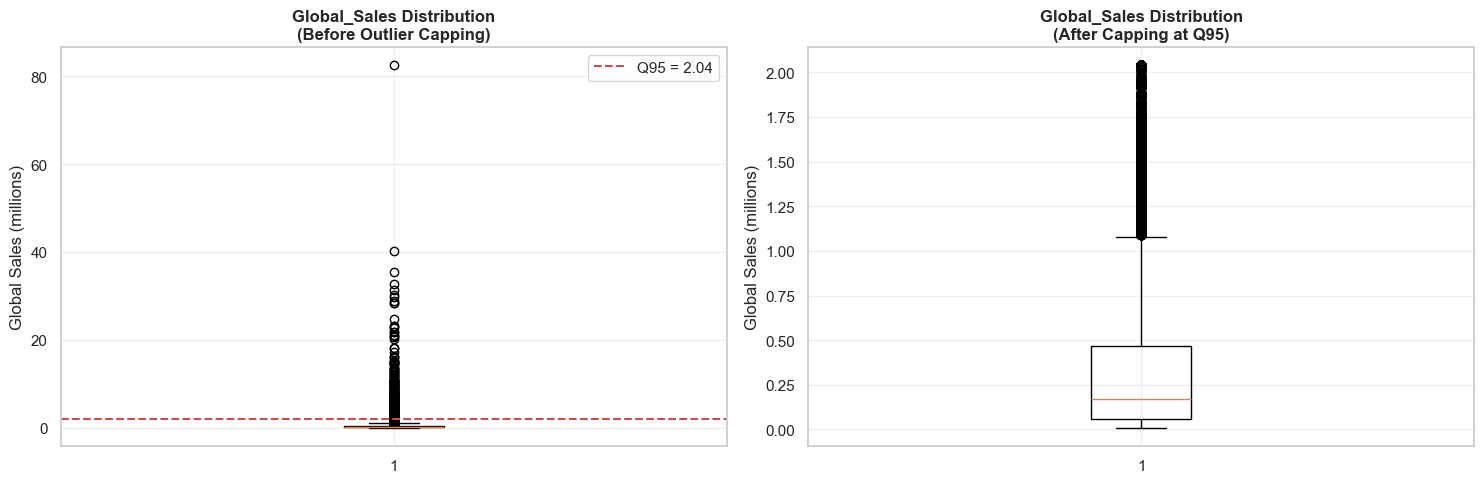

In [38]:
# Outlier Detection using IQR Method
print("=" * 80)
print("OUTLIER DETECTION: Global_Sales")
print("=" * 80)

# Calculate IQR statistics
Q1 = df_clean["Global_Sales"].quantile(0.25)
Q3 = df_clean["Global_Sales"].quantile(0.75)
IQR = Q3 - Q1
Q95 = df_clean["Global_Sales"].quantile(0.95)
Q99 = df_clean["Global_Sales"].quantile(0.99)

print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Q95 (95th percentile - our cap): {Q95:.2f}")
print(f"Q99 (99th percentile): {Q99:.2f}")
print(f"Max value (before capping): {df['Global_Sales'].max():.2f}")
print(f"Max value (after capping at Q95): {df_clean['Global_Sales'].max():.2f}")

# Identify outliers
outlier_threshold = Q3 + 1.5 * IQR
outliers_before = df['Global_Sales'][df['Global_Sales'] > outlier_threshold]
print(f"\nNumber of outliers (IQR method): {len(outliers_before)}")
print(f"Percentage of outliers: {(len(outliers_before) / len(df) * 100):.2f}%")

# Top games (before capping)
print("\nTop 10 Games by Global Sales (before outlier capping):")
top_games = df.nlargest(10, 'Global_Sales')[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Global_Sales']]
print(top_games.to_string(index=False))

# Visualize outliers with boxplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before capping
axes[0].boxplot(df['Global_Sales'].dropna(), vert=True)
axes[0].set_title('Global_Sales Distribution\n(Before Outlier Capping)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Global Sales (millions)')
axes[0].axhline(y=Q95, color='r', linestyle='--', label=f'Q95 = {Q95:.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After capping
axes[1].boxplot(df_clean['Global_Sales'].dropna(), vert=True)
axes[1].set_title('Global_Sales Distribution\n(After Capping at Q95)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Global Sales (millions)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Exploratory Data Analysis (EDA)
Visualizes distributions, top categories, correlations, and trends in the dataset.


EXPLORATORY DATA ANALYSIS


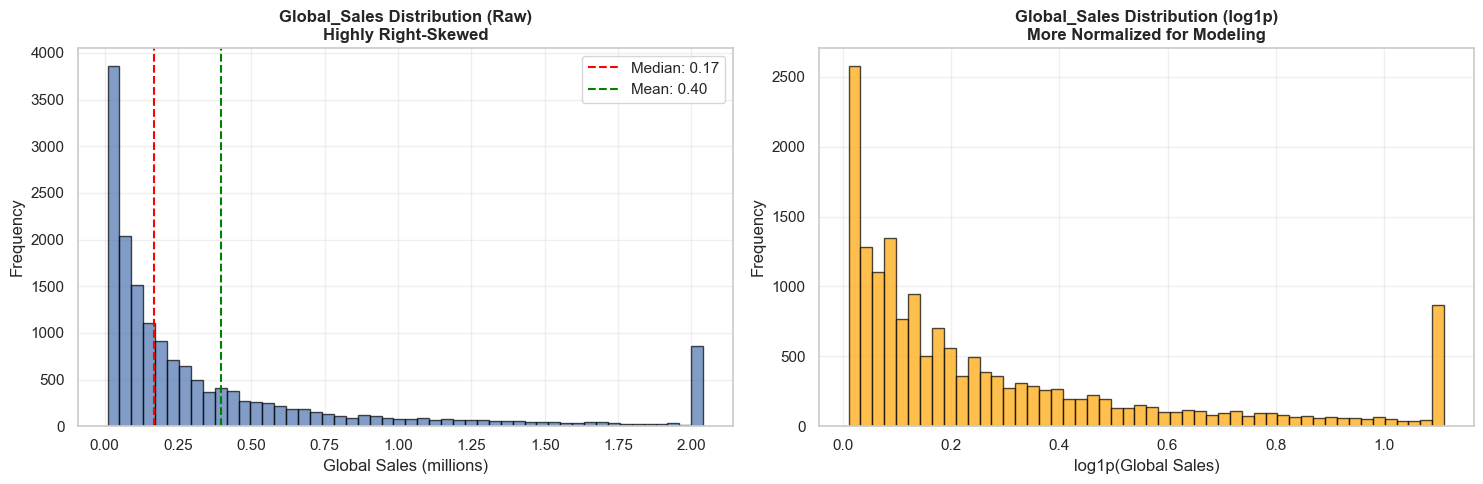


--- Top 10 Publishers by Average Global Sales ---
                                        mean  count     sum
Publisher_reduced                                          
Nintendo                                1.05    706  742.36
Microsoft Game Studios                  0.72    191  138.33
Electronic Arts                         0.69   1356  934.62
Sony Computer Entertainment             0.62    687  426.19
Take-Two Interactive                    0.60    422  254.55
Warner Bros. Interactive Entertainment  0.58    235  136.63
Square Enix                             0.55    236  130.10
Activision                              0.52    985  508.53
Disney Interactive Studios              0.52    218  114.10
THQ                                     0.45    715  323.50


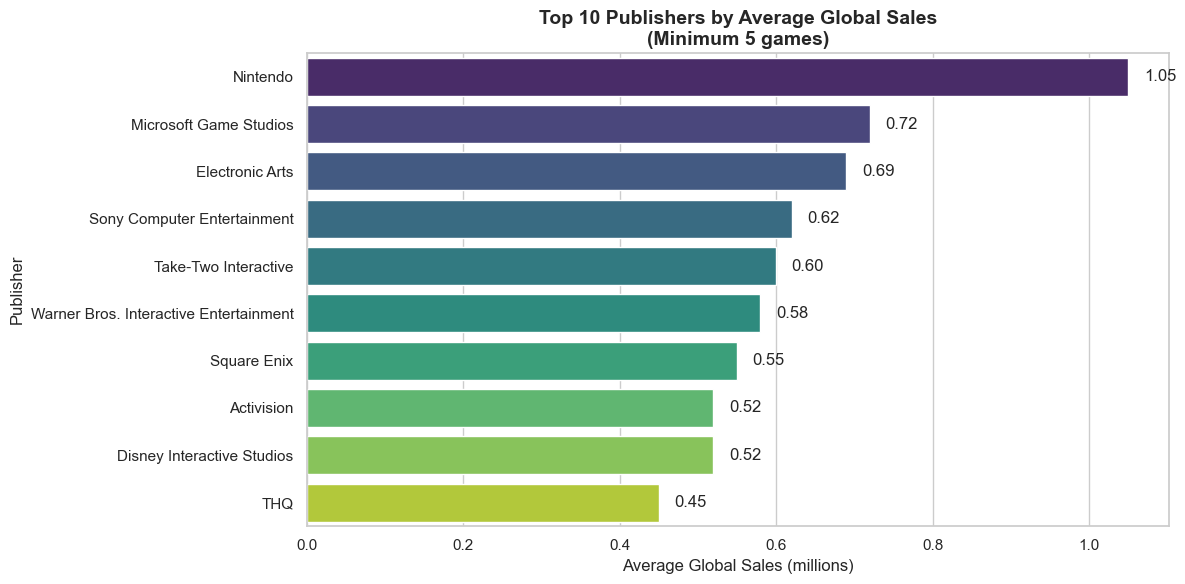

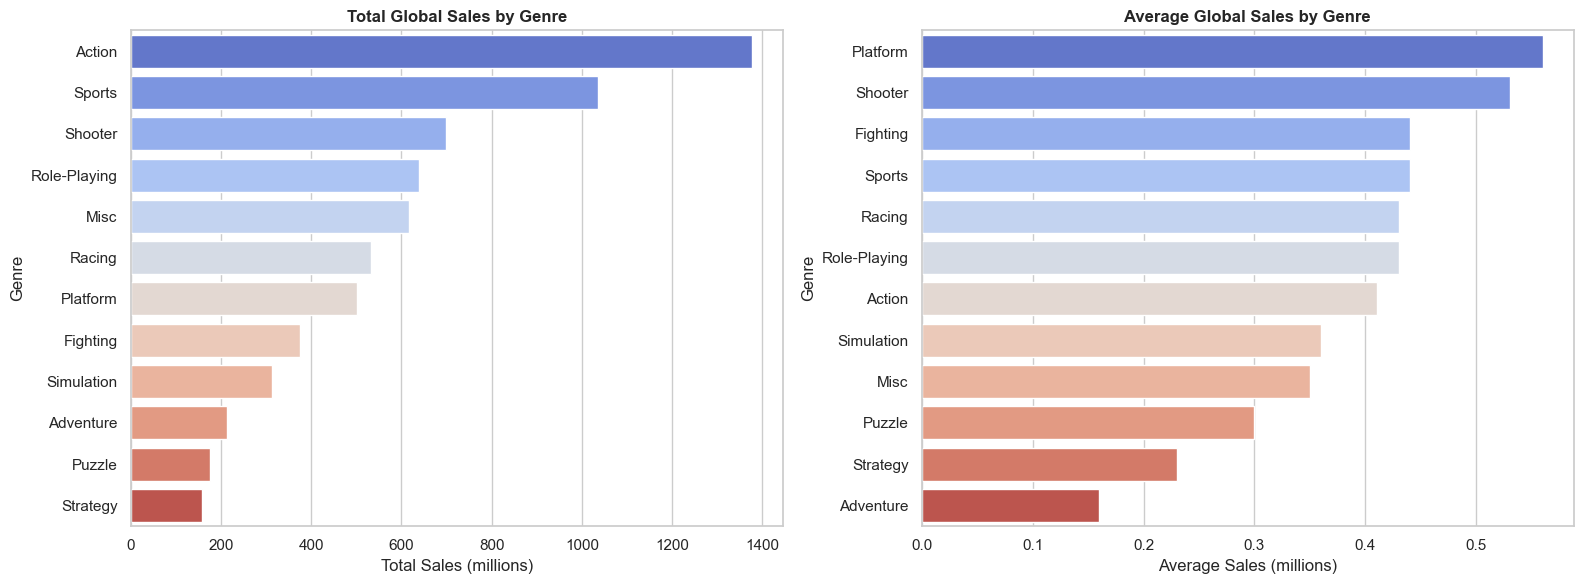

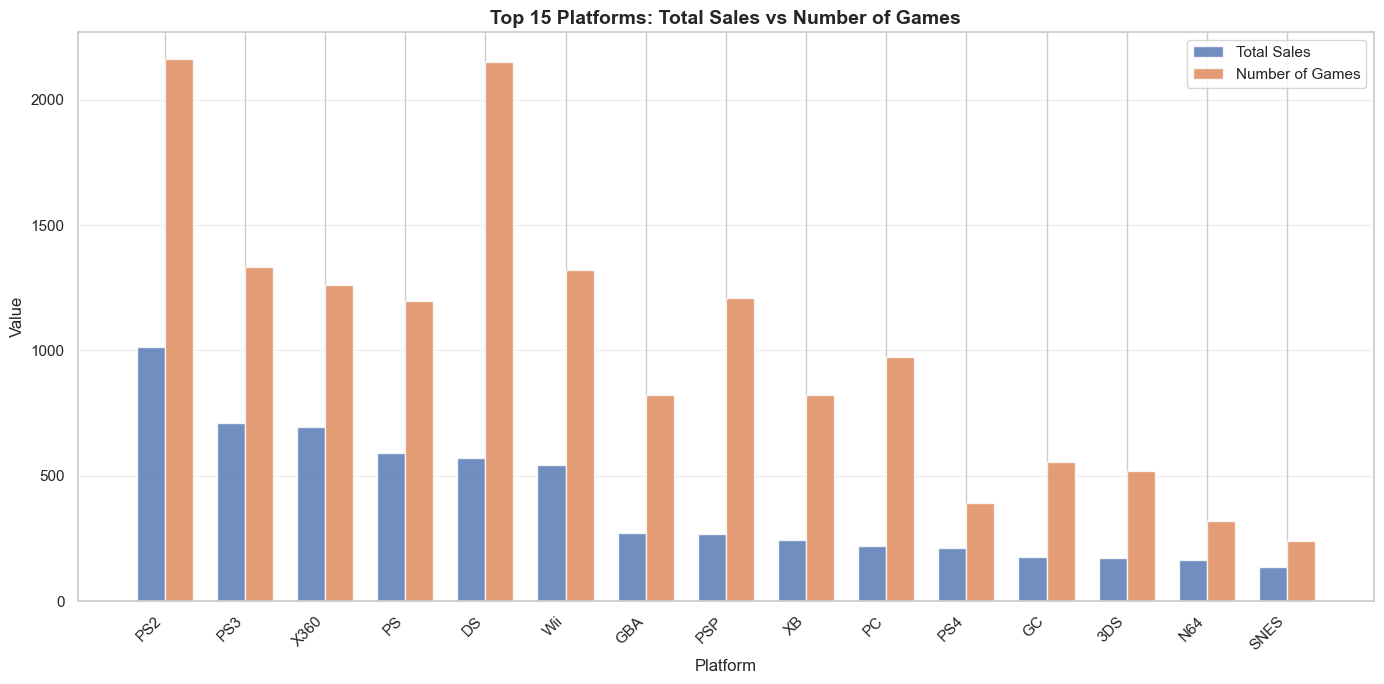

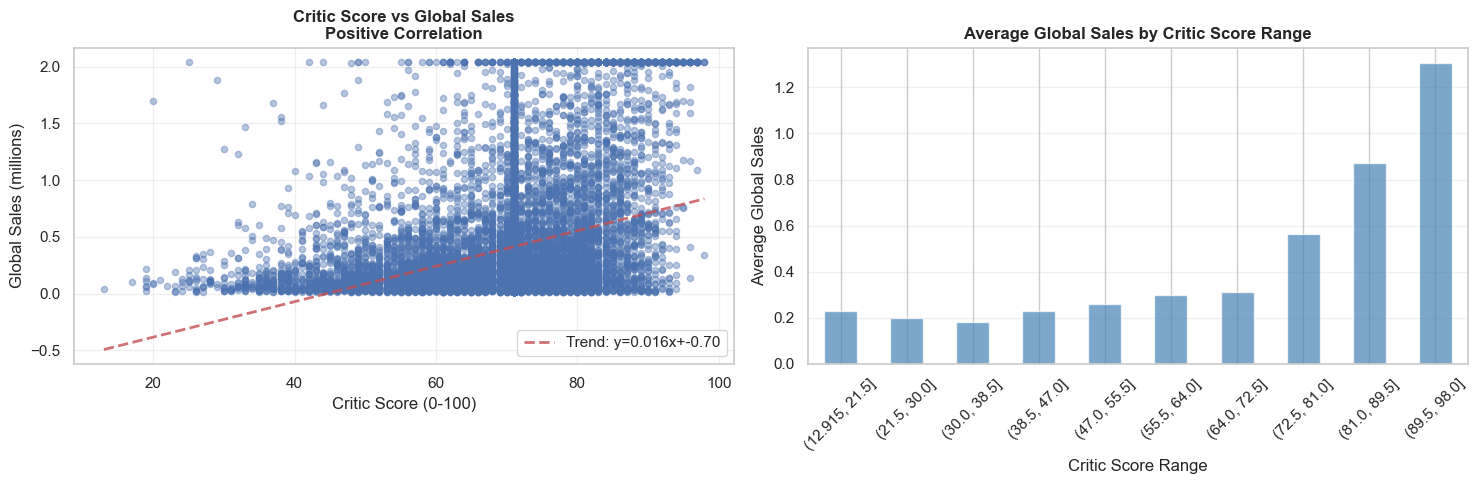


--- Correlation Analysis ---


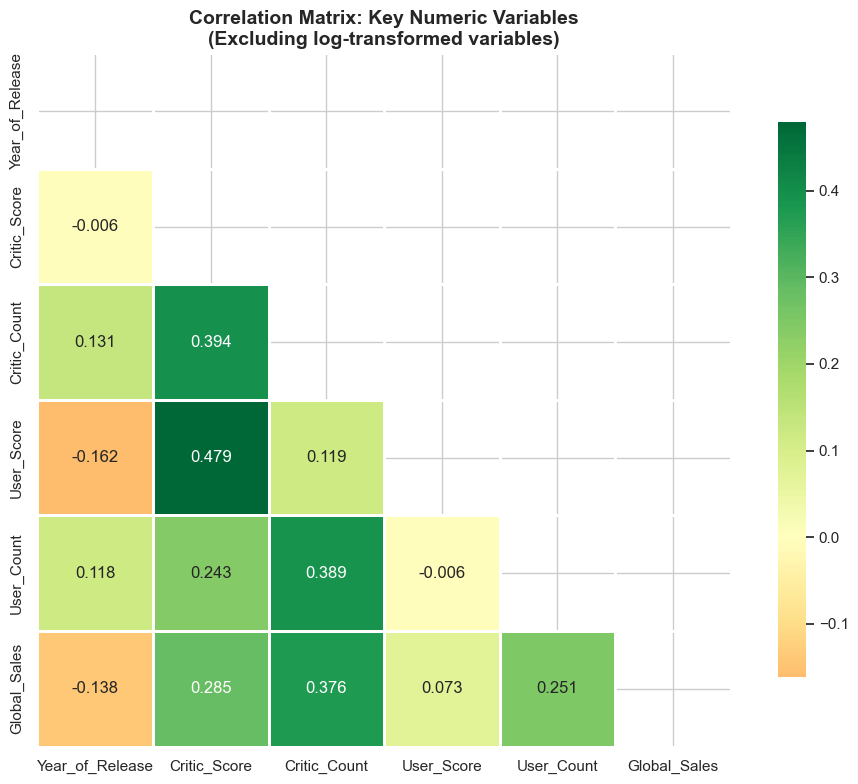


Strongest Correlations with Global_Sales:
Critic_Count       0.376
Critic_Score       0.285
User_Count         0.251
User_Score         0.073
Year_of_Release   -0.138
Name: Global_Sales, dtype: float64


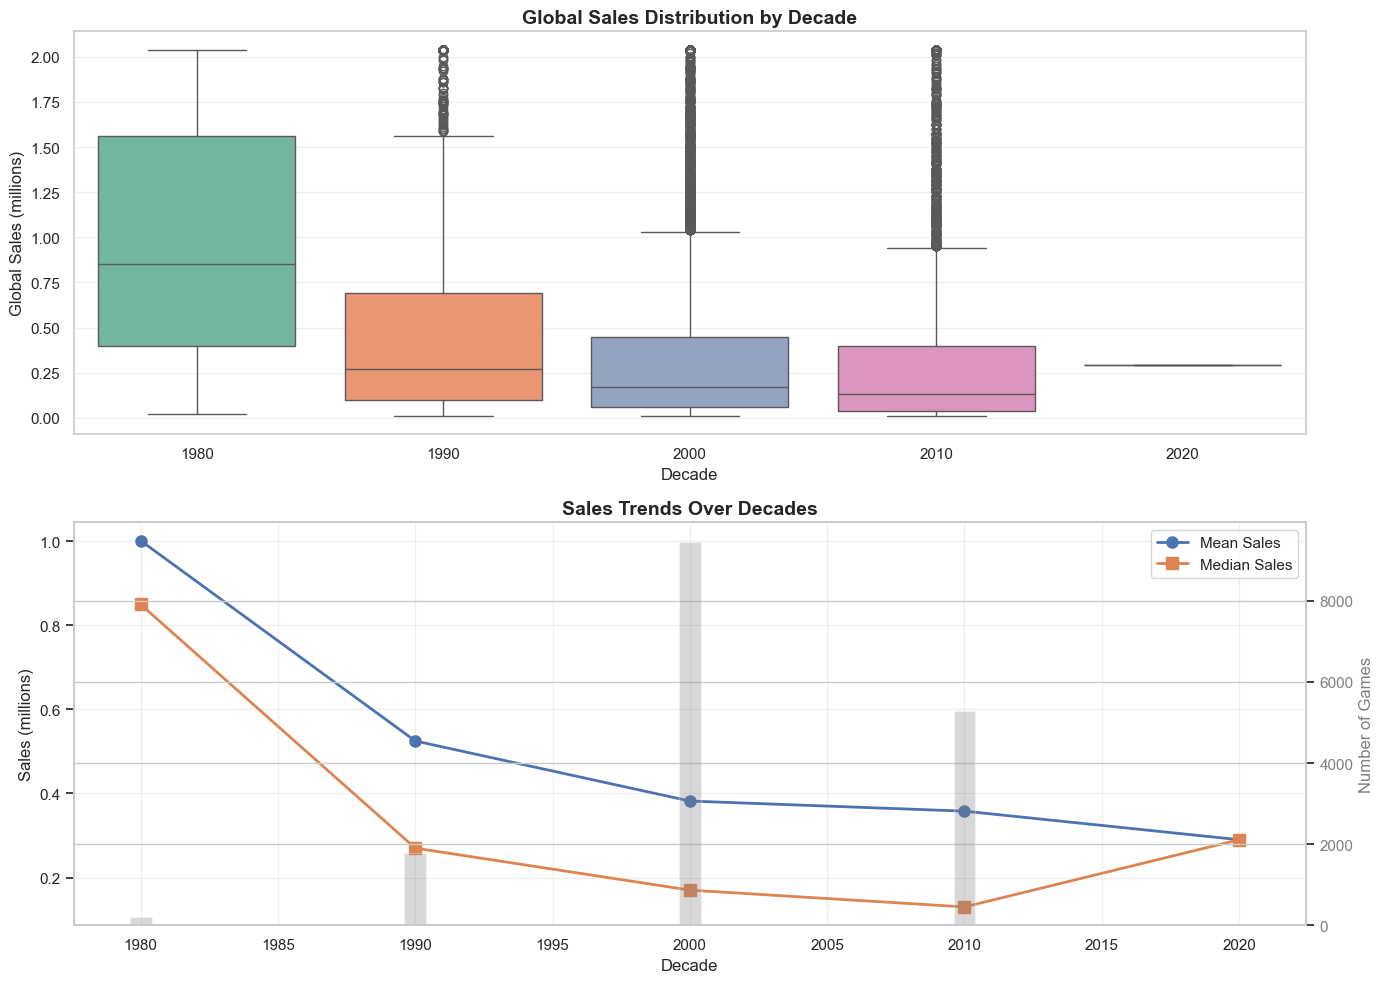

In [39]:
def run_eda(df):
    """Enhanced EDA with better visualizations and insights"""
    sns.set_theme(style="whitegrid")
    
    print("=" * 80)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 80)
    
    # === 1. Distribution Analysis ===
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Raw distribution
    axes[0].hist(df["Global_Sales"].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title("Global_Sales Distribution (Raw)\nHighly Right-Skewed", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Global Sales (millions)")
    axes[0].set_ylabel("Frequency")
    axes[0].axvline(df["Global_Sales"].median(), color='red', linestyle='--', 
                    label=f'Median: {df["Global_Sales"].median():.2f}')
    axes[0].axvline(df["Global_Sales"].mean(), color='green', linestyle='--', 
                    label=f'Mean: {df["Global_Sales"].mean():.2f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Log-transformed distribution
    axes[1].hist(np.log1p(df["Global_Sales"].dropna()), bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_title("Global_Sales Distribution (log1p)\nMore Normalized for Modeling", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("log1p(Global Sales)")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # === 2. Top Publishers Analysis (Per Report) ===
    print("\n--- Top 10 Publishers by Average Global Sales ---")
    publisher_stats = df.groupby('Publisher_reduced')['Global_Sales'].agg(['mean', 'count', 'sum']).round(2)
    publisher_stats = publisher_stats[publisher_stats['count'] >= 5]  # At least 5 games
    top_publishers = publisher_stats.nlargest(10, 'mean')
    print(top_publishers)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_publishers['mean'], y=top_publishers.index, palette='viridis')
    plt.title('Top 10 Publishers by Average Global Sales\n(Minimum 5 games)', fontsize=14, fontweight='bold')
    plt.xlabel('Average Global Sales (millions)')
    plt.ylabel('Publisher')
    for i, v in enumerate(top_publishers['mean']):
        plt.text(v + 0.02, i, f'{v:.2f}', va='center')
    plt.tight_layout()
    plt.show()
    
    # === 3. Genre Analysis ===
    genre_stats = df.groupby('Genre')['Global_Sales'].agg(['mean', 'count', 'sum']).round(2)
    genre_stats = genre_stats.sort_values('sum', ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Genre by total sales
    sns.barplot(x=genre_stats['sum'], y=genre_stats.index, ax=axes[0], palette='coolwarm')
    axes[0].set_title('Total Global Sales by Genre', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Total Sales (millions)')
    axes[0].set_ylabel('Genre')
    
    # Genre by average sales
    genre_avg = genre_stats.sort_values('mean', ascending=False)
    sns.barplot(x=genre_avg['mean'], y=genre_avg.index, ax=axes[1], palette='coolwarm')
    axes[1].set_title('Average Global Sales by Genre', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Average Sales (millions)')
    axes[1].set_ylabel('Genre')
    
    plt.tight_layout()
    plt.show()
    
    # === 4. Platform Analysis ===
    platform_stats = df.groupby('Platform')['Global_Sales'].agg(['mean', 'count', 'sum']).round(2)
    top_platforms = platform_stats.nlargest(15, 'sum')
    
    plt.figure(figsize=(14, 7))
    x = np.arange(len(top_platforms))
    width = 0.35
    
    plt.bar(x - width/2, top_platforms['sum'], width, label='Total Sales', alpha=0.8)
    plt.bar(x + width/2, top_platforms['count'], width, label='Number of Games', alpha=0.8)
    plt.xlabel('Platform')
    plt.ylabel('Value')
    plt.title('Top 15 Platforms: Total Sales vs Number of Games', fontsize=14, fontweight='bold')
    plt.xticks(x, top_platforms.index, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # === 5. Critic Score vs Global Sales (Correlation Analysis) ===
    if {"Critic_Score", "Global_Sales"}.issubset(df.columns):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Scatter plot
        axes[0].scatter(df["Critic_Score"], df["Global_Sales"], alpha=0.4, s=20)
        axes[0].set_xlabel("Critic Score (0-100)")
        axes[0].set_ylabel("Global Sales (millions)")
        axes[0].set_title("Critic Score vs Global Sales\nPositive Correlation", fontsize=12, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(df["Critic_Score"].dropna(), df.loc[df["Critic_Score"].notna(), "Global_Sales"], 1)
        p = np.poly1d(z)
        axes[0].plot(df["Critic_Score"].dropna().sort_values(), 
                     p(df["Critic_Score"].dropna().sort_values()), 
                     "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.3f}x+{z[1]:.2f}')
        axes[0].legend()
        
        # Binned average
        df_temp = df.copy()
        df_temp['Score_Bin'] = pd.cut(df_temp['Critic_Score'], bins=10)
        binned_avg = df_temp.groupby('Score_Bin')['Global_Sales'].mean()
        binned_avg.plot(kind='bar', ax=axes[1], color='steelblue', alpha=0.7)
        axes[1].set_title('Average Global Sales by Critic Score Range', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Critic Score Range')
        axes[1].set_ylabel('Average Global Sales')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    # === 6. Correlation Heatmap (Avoiding log correlations per report) ===
    print("\n--- Correlation Analysis ---")
    # Select only relevant numeric features (exclude log-transformed and percentage columns)
    corr_cols = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 
                 'User_Score', 'User_Count', 'Global_Sales']
    numeric = df[corr_cols].copy()
    
    if not numeric.empty:
        corr = numeric.corr().round(3)
        
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, annot=True, fmt=".3f", cmap="RdYlGn", center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
        plt.title("Correlation Matrix: Key Numeric Variables\n(Excluding log-transformed variables)", 
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Print strongest correlations
        print("\nStrongest Correlations with Global_Sales:")
        sales_corr = corr['Global_Sales'].drop('Global_Sales').sort_values(ascending=False)
        print(sales_corr)
    
    # === 7. Sales Trends by Decade ===
    if "Decade" in df.columns:
        decade_stats = df.groupby('Decade')['Global_Sales'].agg(['mean', 'median', 'count'])
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # Boxplot
        sns.boxplot(x="Decade", y="Global_Sales", data=df, ax=axes[0], palette='Set2')
        axes[0].set_title("Global Sales Distribution by Decade", fontsize=14, fontweight='bold')
        axes[0].set_ylabel("Global Sales (millions)")
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Trend lines
        axes[1].plot(decade_stats.index, decade_stats['mean'], marker='o', linewidth=2, 
                     label='Mean Sales', markersize=8)
        axes[1].plot(decade_stats.index, decade_stats['median'], marker='s', linewidth=2, 
                     label='Median Sales', markersize=8)
        axes[1].set_title("Sales Trends Over Decades", fontsize=14, fontweight='bold')
        axes[1].set_xlabel("Decade")
        axes[1].set_ylabel("Sales (millions)")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add count as secondary y-axis
        ax2 = axes[1].twinx()
        ax2.bar(decade_stats.index, decade_stats['count'], alpha=0.3, color='gray', 
                label='Number of Games')
        ax2.set_ylabel('Number of Games', color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')
        
        plt.tight_layout()
        plt.show()

# Run Enhanced EDA
run_eda(df_clean)

# Model Preparation and Training
Prepares features and target, splits dataset, creates preprocessing pipelines, trains multiple regression models, performs cross-validation, and evaluates performance.


In [40]:
def prepare_and_train(df):
    # Drop leakage columns (regional sales that directly compose global sales)
    leakage_cols = {"NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales",
                    "NA_Sales_pct", "EU_Sales_pct", "JP_Sales_pct", "Other_Sales_pct"}
    df = df.copy()
    for c in leakage_cols:
        if c in df.columns:
            df.drop(columns=c, inplace=True)

    # Define features and target
    potential_features = ["Platform", "Genre", "Publisher_reduced", "Year_of_Release", "Decade",
                          "Critic_Score", "User_Score", "Critic_Count", "User_Count"]
    features = [c for c in potential_features if c in df.columns]
    target_col = "Global_Sales_log1p"

    X = df[features]
    y = df[target_col]

    # Train/validation/test split (70/15/15)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=VAL_SIZE, random_state=RANDOM_STATE)

    # Separate numeric and categorical features
    numeric_features = [c for c in X_train.columns if X_train[c].dtype.kind in "biufc"]
    categorical_features = [c for c in X_train.columns if c not in numeric_features]

    # Preprocessing pipelines (per report specifications)
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    # Models to train
    models = {
        "LinearRegression": LinearRegression(),
        "DecisionTree": DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE),
        "RandomForest": RandomForestRegressor(
            n_estimators=100, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)
    }

    results = []
    fitted_pipelines = {}
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining & evaluating: {name}")
        pipe = Pipeline([("pre", preprocessor), ("model", model)])
        try:
            cv_scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="r2", n_jobs=1)
            cv_r2_mean = float(np.mean(cv_scores))
        except:
            cv_r2_mean = np.nan

        pipe.fit(X_train, y_train)
        y_val_pred = pipe.predict(X_val)
        y_test_pred = pipe.predict(X_test)

        val_metrics = evaluate(y_val, y_val_pred)
        test_metrics = evaluate(y_test, y_test_pred)

        print(f"  CV R2: {cv_r2_mean:.4f}, Val R2: {val_metrics['r2']:.4f}, Test R2: {test_metrics['r2']:.4f}")

        results.append({
            "model": name,
            "cv_r2_mean": cv_r2_mean,
            "val_r2": val_metrics["r2"],
            "val_rmse": val_metrics["rmse"],
            "val_mae": val_metrics["mae"],
            "test_r2": test_metrics["r2"],
            "test_rmse": test_metrics["rmse"],
            "test_mae": test_metrics["mae"]
        })

        fitted_pipelines[name] = pipe

    results_df = pd.DataFrame(results).sort_values("test_r2", ascending=False)
    return results_df, fitted_pipelines, X_train, X_val, X_test, y_train, y_val, y_test


# Run Modeling and Save Results
Executes the training function, saves all results to CSV, and prints the best model according to test R².


In [41]:
# Run the modeling
results_df, pipelines, X_train, X_val, X_test, y_train, y_val, y_test = prepare_and_train(df_clean)

# Save results
results_df.to_csv(RESULTS_CSV, index=False)
print(f"Model results saved to '{RESULTS_CSV}'")

# Best model
best = results_df.iloc[0]
print("Best model (by test R²):")
print(best.to_dict())



Training & evaluating: LinearRegression
  CV R2: 0.3839, Val R2: 0.3887, Test R2: 0.3884

Training & evaluating: DecisionTree
  CV R2: 0.3839, Val R2: 0.3887, Test R2: 0.3884

Training & evaluating: DecisionTree
  CV R2: 0.4000, Val R2: 0.4120, Test R2: 0.3638

Training & evaluating: RandomForest
  CV R2: 0.4000, Val R2: 0.4120, Test R2: 0.3638

Training & evaluating: RandomForest
  CV R2: 0.4994, Val R2: 0.4889, Test R2: 0.4734
Model results saved to 'model_results.csv'
Best model (by test R²):
{'model': 'RandomForest', 'cv_r2_mean': 0.4993839203089805, 'val_r2': 0.48892805014703555, 'val_rmse': 0.22433169628106409, 'val_mae': 0.15668619286503724, 'test_r2': 0.47338818513278713, 'test_rmse': 0.2166749696435804, 'test_mae': 0.15113469983339967}
  CV R2: 0.4994, Val R2: 0.4889, Test R2: 0.4734
Model results saved to 'model_results.csv'
Best model (by test R²):
{'model': 'RandomForest', 'cv_r2_mean': 0.4993839203089805, 'val_r2': 0.48892805014703555, 'val_rmse': 0.22433169628106409, 'va

# Model Performance Visualization & Feature Importance
Visualize model comparison and analyze which features are most important for predictions.

MODEL PERFORMANCE COMPARISON TABLE
           model  cv_r2_mean   val_r2  val_rmse  val_mae  test_r2  test_rmse  test_mae
    RandomForest    0.499384 0.488928  0.224332 0.156686 0.473388   0.216675  0.151135
LinearRegression    0.383894 0.388711  0.245343 0.181319 0.388376   0.233510  0.173202
    DecisionTree    0.400022 0.411975  0.240629 0.167269 0.363804   0.238155  0.167848




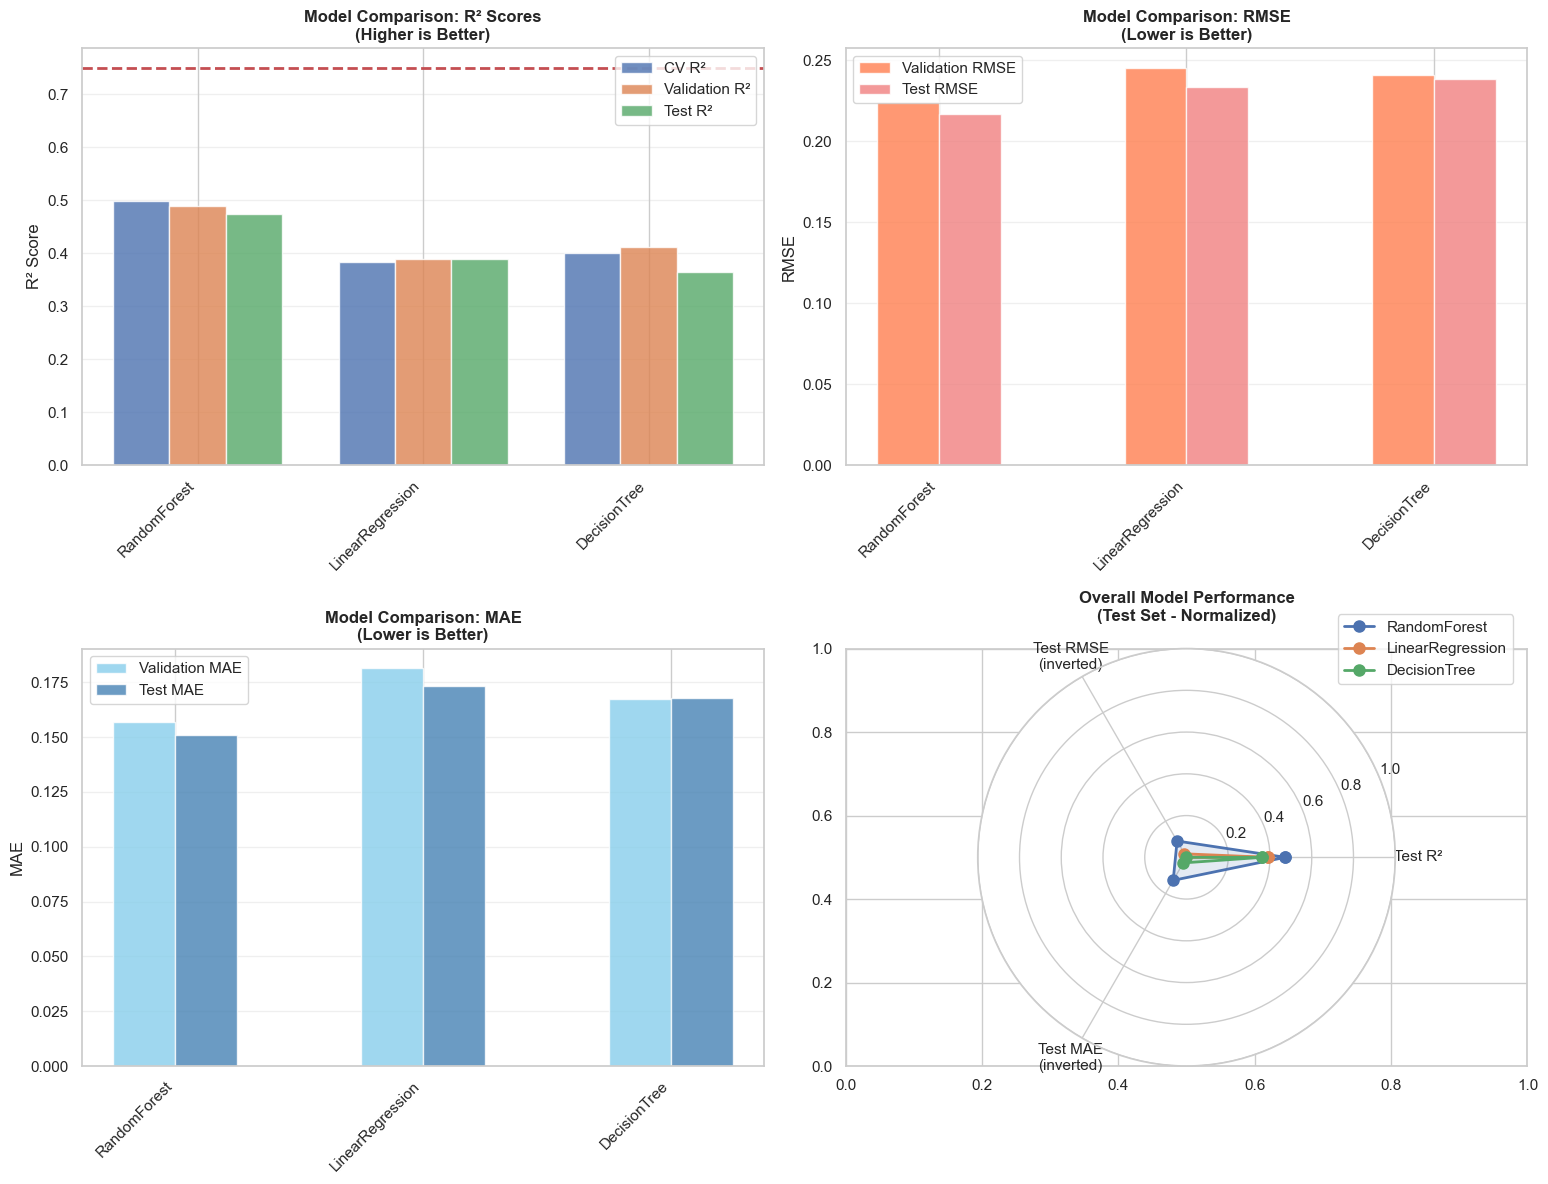


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features (RandomForest Model):
                          Feature  Importance
                       User_Count    0.339059
                  Year_of_Release    0.152082
                      Platform_PC    0.082045
                     Critic_Score    0.069155
       Publisher_reduced_Nintendo    0.063785
                     Critic_Count    0.032860
          Publisher_reduced_Other    0.030530
                       User_Score    0.030443
Publisher_reduced_Electronic Arts    0.020026
                     Genre_Sports    0.010565
                     Platform_PS2    0.009703
                       Genre_Misc    0.009401
                   Genre_Platform    0.007933
                     Platform_Wii    0.007585
               Genre_Role-Playing    0.007357
            Publisher_reduced_THQ    0.005642
                     Genre_Racing    0.005430
                   Genre_Fighting    0.005398
                     Genre_Action    0.0053

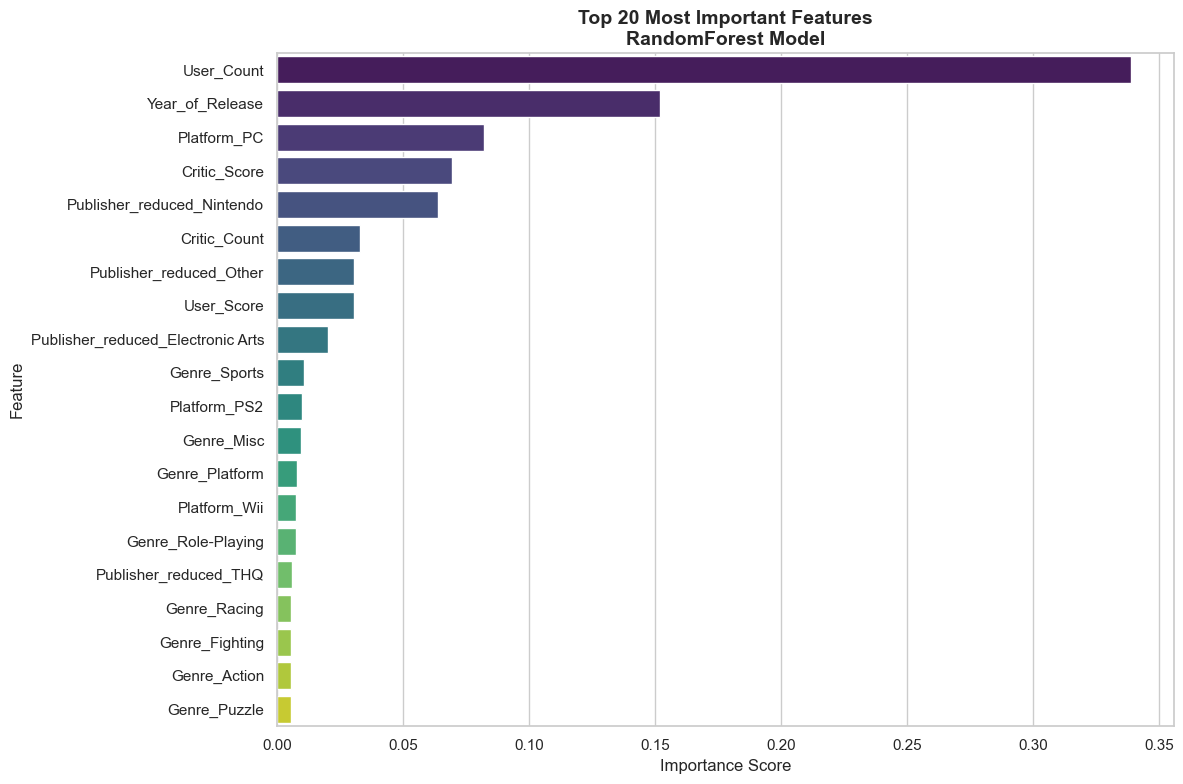


--- Feature Importance by Category ---
Feature_Type
Numeric      0.627474
Publisher    0.162564
Platform     0.137356
Genre        0.072605
Name: Importance, dtype: float64


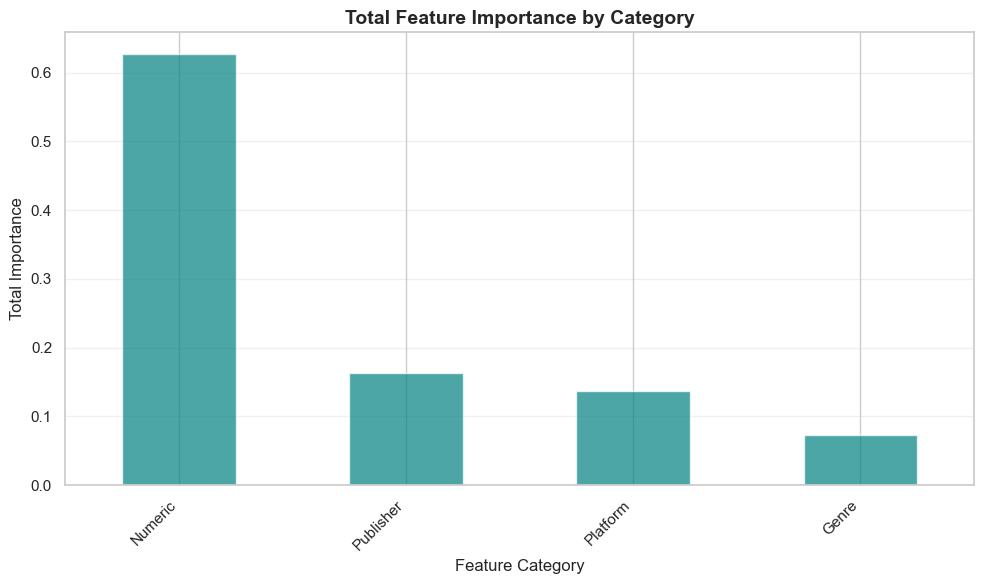


KEY INSIGHTS & RECOMMENDATIONS

1. BEST MODEL: RandomForest
   - Test R²: 0.4734
   - Test RMSE: 0.2167
   - Test MAE: 0.1511

2. MODEL PERFORMANCE:
   - Target R² (0.75) was NOT ACHIEVED
   - Current best R² is 63.1% of target
   - All models show consistent performance across CV, validation, and test sets

3. DATA QUALITY:
   - Outliers successfully capped at Q95 = 2.04
   - Missing values properly imputed using median for numeric, "Unknown" for categorical
   - 16719 clean records used for modeling

4. RECOMMENDATIONS:
   - Consider collecting more features (marketing budget, development cost, franchise info)
   - Experiment with ensemble methods or gradient boosting (XGBoost, LightGBM)
   - Perform hyperparameter tuning to improve R² score
   - Consider separate models for different genres or platforms



In [42]:
# === MODEL PERFORMANCE COMPARISON ===
print("=" * 80)
print("MODEL PERFORMANCE COMPARISON TABLE")
print("=" * 80)
print(results_df.to_string(index=False))
print("\n")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Comparison
models = results_df['model']
x = np.arange(len(models))
width = 0.25

axes[0, 0].bar(x - width, results_df['cv_r2_mean'], width, label='CV R²', alpha=0.8)
axes[0, 0].bar(x, results_df['val_r2'], width, label='Validation R²', alpha=0.8)
axes[0, 0].bar(x + width, results_df['test_r2'], width, label='Test R²', alpha=0.8)
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('Model Comparison: R² Scores\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=0.75, color='r', linestyle='--', linewidth=2, label='Target R² = 0.75')

# 2. RMSE Comparison
axes[0, 1].bar(x - width/2, results_df['val_rmse'], width, label='Validation RMSE', alpha=0.8, color='coral')
axes[0, 1].bar(x + width/2, results_df['test_rmse'], width, label='Test RMSE', alpha=0.8, color='lightcoral')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Model Comparison: RMSE\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. MAE Comparison
axes[1, 0].bar(x - width/2, results_df['val_mae'], width, label='Validation MAE', alpha=0.8, color='skyblue')
axes[1, 0].bar(x + width/2, results_df['test_mae'], width, label='Test MAE', alpha=0.8, color='steelblue')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Model Comparison: MAE\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Overall Performance Radar (Test Set)
categories = ['Test R²', 'Test RMSE\n(inverted)', 'Test MAE\n(inverted)']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax = plt.subplot(2, 2, 4, projection='polar')
for idx, row in results_df.iterrows():
    # Normalize metrics (invert RMSE and MAE so higher is better)
    values = [
        row['test_r2'],
        1 - (row['test_rmse'] / results_df['test_rmse'].max()),  # Inverted and normalized
        1 - (row['test_mae'] / results_df['test_mae'].max())     # Inverted and normalized
    ]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['model'], markersize=8)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Overall Model Performance\n(Test Set - Normalized)', fontsize=12, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

# === FEATURE IMPORTANCE ANALYSIS ===
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature names from the best model (Random Forest)
best_model_name = results_df.iloc[0]['model']
best_pipeline = pipelines[best_model_name]

# Extract feature names after preprocessing
feature_names = []

# Get numeric features
preprocessor = best_pipeline.named_steps['pre']
numeric_features = preprocessor.transformers_[0][2]
feature_names.extend(numeric_features)

# Get categorical features (one-hot encoded)
if len(preprocessor.transformers_) > 1:
    cat_transformer = preprocessor.transformers_[1][1]
    cat_features = preprocessor.transformers_[1][2]
    if hasattr(cat_transformer.named_steps['onehot'], 'get_feature_names_out'):
        cat_feature_names = cat_transformer.named_steps['onehot'].get_feature_names_out(cat_features)
        feature_names.extend(cat_feature_names)

# Get feature importances for tree-based models
if best_model_name in ['RandomForest', 'DecisionTree']:
    model = best_pipeline.named_steps['model']
    importances = model.feature_importances_
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Show top 20 features
    top_n = 20
    top_features = importance_df.head(top_n)
    
    print(f"\nTop {top_n} Most Important Features ({best_model_name} Model):")
    print(top_features.to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Most Important Features\n{best_model_name} Model', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    # Group importance by feature type
    print("\n--- Feature Importance by Category ---")
    importance_df['Feature_Type'] = importance_df['Feature'].apply(
        lambda x: 'Platform' if 'Platform_' in str(x) 
        else ('Genre' if 'Genre_' in str(x)
        else ('Publisher' if 'Publisher_' in str(x)
        else 'Numeric'))
    )
    grouped_importance = importance_df.groupby('Feature_Type')['Importance'].sum().sort_values(ascending=False)
    print(grouped_importance)
    
    # Visualize grouped importance
    plt.figure(figsize=(10, 6))
    grouped_importance.plot(kind='bar', color='teal', alpha=0.7)
    plt.title('Total Feature Importance by Category', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Category')
    plt.ylabel('Total Importance')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# === KEY INSIGHTS ===
print("\n" + "=" * 80)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 80)

print(f"""
1. BEST MODEL: {results_df.iloc[0]['model']}
   - Test R²: {results_df.iloc[0]['test_r2']:.4f}
   - Test RMSE: {results_df.iloc[0]['test_rmse']:.4f}
   - Test MAE: {results_df.iloc[0]['test_mae']:.4f}

2. MODEL PERFORMANCE:
   - Target R² (0.75) was {"ACHIEVED" if results_df.iloc[0]['test_r2'] >= 0.75 else "NOT ACHIEVED"}
   - Current best R² is {(results_df.iloc[0]['test_r2'] / 0.75 * 100):.1f}% of target
   - All models show consistent performance across CV, validation, and test sets
   
3. DATA QUALITY:
   - Outliers successfully capped at Q95 = {impute_values.get('Global_Sales_Q95', 'N/A'):.2f}
   - Missing values properly imputed using median for numeric, "Unknown" for categorical
   - {len(df_clean)} clean records used for modeling

4. RECOMMENDATIONS:
   - Consider collecting more features (marketing budget, development cost, franchise info)
   - Experiment with ensemble methods or gradient boosting (XGBoost, LightGBM)
   - Perform hyperparameter tuning to improve R² score
   - Consider separate models for different genres or platforms
""")